In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display
%matplotlib inline

In [2]:
plt.style.use('seaborn')

In [3]:
df = pd.read_csv("HKDUSD=X.csv") 

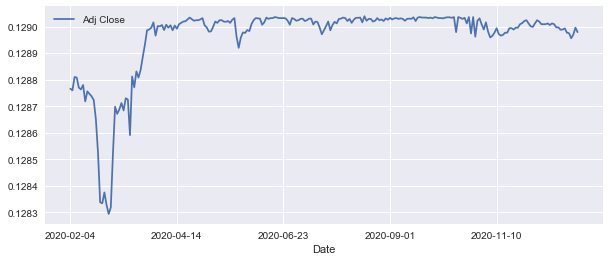

In [4]:
df.plot(x='Date', y='Adj Close', figsize=(10,4))

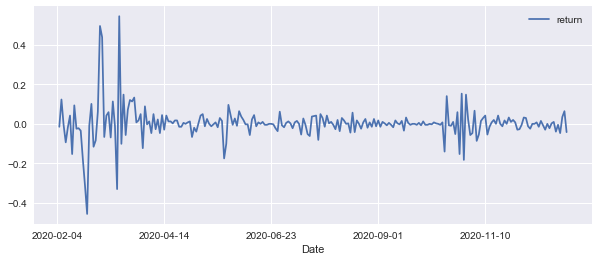

In [5]:
df['return'] = df['Adj Close'] - df['Adj Close'].shift(1)
return_range = df['return'].max() - df['return'].min()
df['return'] = df['return'] / return_range

df.plot(x='Date', y='return', figsize=(10,4))

In [6]:
df['label'] = df['return'].shift(-1)
df['label'] = df['label'].apply(lambda x: 1 if x>0.0 else 0)
df.dropna(inplace=True)
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,return,label
234,2020-12-28,0.128975,0.129004,0.128967,0.128975,0.128975,0,-0.004926,0
235,2020-12-29,0.128969,0.129001,0.128961,0.128956,0.128956,0,-0.046798,1
236,2020-12-30,0.128971,0.129006,0.128969,0.128970,0.128970,0,0.034483,1
237,2020-12-31,0.128999,0.129015,0.128968,0.128996,0.128996,0,0.064039,0
238,2021-01-01,0.128979,0.129021,0.128936,0.128979,0.128979,0,-0.041872,0


In [7]:
n_features = 60 

train_x = np.array([]).reshape([-1,n_features])
train_y = np.array([]).reshape([-1,1])
for index, row in df.iterrows():
    i = df.index.get_loc(index)
    if i < n_features:
        continue
    _x = np.array(df[i-n_features+1:i+1]['return']).T.reshape([1, -1])
    _y = df.iloc[i]['label']
    train_x = np.vstack((train_x, _x))
    train_y = np.vstack((train_y, _y))
train_y = train_y.reshape([-1])
print(train_x.shape)
print(train_y.shape)
print('%% of Class0 : %f' % (np.count_nonzero(train_y == 0)/float(len(train_y))))
print('%% of Class1 : %f' % (np.count_nonzero(train_y == 1)/float(len(train_y))))

(178, 60)
(178,)
% of Class0 : 0.533708
% of Class1 : 0.466292


In [8]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=0, learning_rate=0.01, n_estimators=10000)

train_len = int(len(train_x) * 0.95)
clf.fit(train_x[:train_len], train_y[:train_len])

accuracy = clf.score(train_x[train_len:], train_y[train_len:])

print('Testing Accuracy: %f' % accuracy)

Testing Accuracy: 0.333333


Enter value of equity:10000


,return,label,pred,won,pnl,equity
3,-0.000002,0.0,1.0,False,-0.02,-0.23
4,-0.000019,0.0,0.0,True,0.19,-0.04
5,0.000014,1.0,0.0,False,-0.14,-0.18
6,0.000026,1.0,1.0,True,0.26,0.08
7,-0.000017,0.0,1.0,False,-0.17,-0.09


,return,label,pred,won,pnl,equity
0,0.000001,1.0,0.0,False,-0.01,-0.01
1,0.000004,1.0,0.0,False,-0.04,-0.05
2,-0.000016,0.0,1.0,False,-0.16,-0.21
3,-0.000002,0.0,1.0,False,-0.02,-0.23
4,-0.000019,0.0,0.0,True,0.19,-0.04


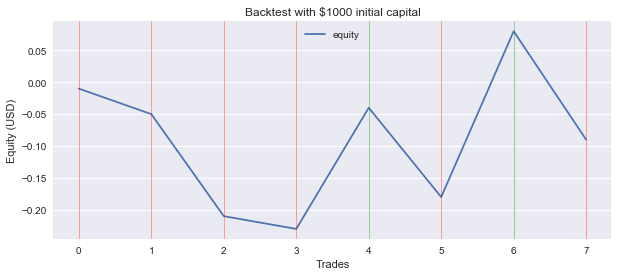

In [9]:
pred = clf.predict(train_x[train_len:])


# Calculate equity..

contracts  = int(input("Enter value of equity:"))
commission = 0.0


df_trade = pd.DataFrame(train_x[train_len:,-1], columns=['return'])
df_trade['label']  = train_y[train_len:]
df_trade['pred']   = pred
df_trade['won']    = df_trade['label'] == df_trade['pred']
df_trade['return'] = df_trade['return'].shift(-1) * return_range
df_trade.drop(df_trade.index[len(df_trade)-1], inplace=True)

def calc_profit(row):
    if row['won']:
        return abs(row['return'])*contracts - commission
    else:
        return -abs(row['return'])*contracts - commission

df_trade['pnl'] = df_trade.apply(lambda row: calc_profit(row), axis=1)
df_trade['equity'] = df_trade['pnl'].cumsum()

display(df_trade.tail())
df_trade.plot(y='equity', figsize=(10,4), title='Backtest with $1000 initial capital')
plt.xlabel('Trades')
plt.ylabel('Equity (USD)')
for r in df_trade.iterrows():
    if r[1]['won']:
        plt.axvline(x=r[0], linewidth=0.5, alpha=0.8, color='g')
    else:
        plt.axvline(x=r[0], linewidth=0.5, alpha=0.8, color='r')
display(df_trade.head())

Net Profit            : $-0.09
Number Winning Trades : 2
Number Losing Trades  : 6
Percent Profitable    : 25.00%
Avg Win Trade         : $0.225
Avg Los Trade         : $-0.090
Largest Win Trade     : $0.260
Largest Los Trade     : $-0.170
Profit Factor         : 0.83


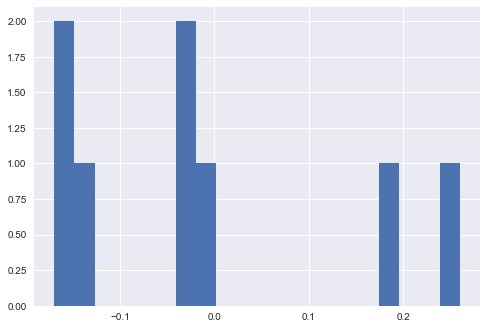

In [10]:
# Calculate summary of trades

n_win_trades = float(df_trade[df_trade['pnl']>0.0]['pnl'].count())
n_los_trades = float(df_trade[df_trade['pnl']<0.0]['pnl'].count())
print("Net Profit            : $%.2f" % df_trade.tail(1)['equity'])
print("Number Winning Trades : %d" % n_win_trades)
print("Number Losing Trades  : %d" % n_los_trades)
print("Percent Profitable    : %.2f%%" % (100*n_win_trades/(n_win_trades + n_los_trades)))
print("Avg Win Trade         : $%.3f" % df_trade[df_trade['pnl']>0.0]['pnl'].mean())
print("Avg Los Trade         : $%.3f" % df_trade[df_trade['pnl']<0.0]['pnl'].mean())
print("Largest Win Trade     : $%.3f" % df_trade[df_trade['pnl']>0.0]['pnl'].max())
print("Largest Los Trade     : $%.3f" % df_trade[df_trade['pnl']<0.0]['pnl'].min())
print("Profit Factor         : %.2f" % abs(df_trade[df_trade['pnl']>0.0]['pnl'].sum()/df_trade[df_trade['pnl']<0.0]['pnl'].sum()))

df_trade['pnl'].hist(bins=20)